## This jupyter notebook contains the code that I will run during the 2021 IPN Summer School on graph theory.

author: Vincent Bazinet

## Let's first setup our jupyter notebook

In [1]:
import os  # Basic library to do OS-related operations
import numpy as np  # Library for array/matrices computations

# Let's first change the current working directory (set this path to the path in which you have downloaded the data)
path = "/OneDrive - McGill University/Summer School/tutorial"
os.chdir(os.path.expanduser("~") + path)

# We then need to load actual connectivity matrices
SC = np.load("SC.npy")
FC = np.load("FC.npy")

# We also want coordinates for the individual brain regions
coords = np.load("coords.npy")

In [2]:
# Let's keep our notebook clean, so it's a little more readable!
import warnings
warnings.filterwarnings('ignore')

## Now, we are ready to visualize, and play around with our data

- ### We can visualize the network with its spatial coordinates

        Here, we are using a parcellation of 1000 nodes (Cammoun et al., 2012, Journal of Neuroscience Methods).

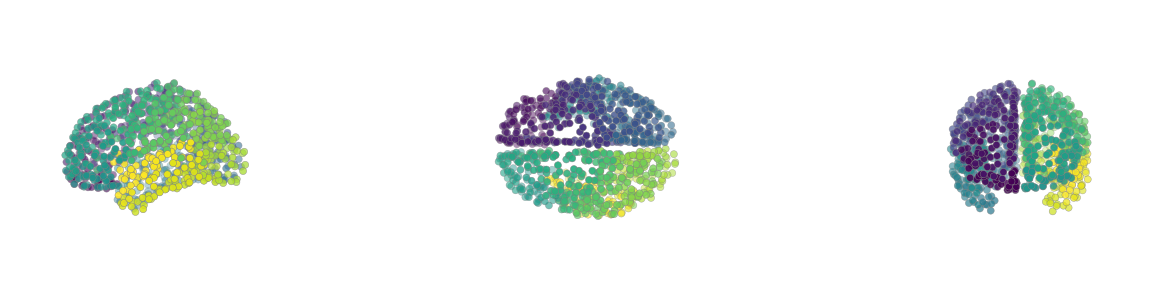

In [3]:
from netneurotools.plotting import plot_point_brain

fig = plot_point_brain(np.arange(1000), coords, views=['sag', 'ax', 'cor'],
                       views_orientation='horizontal', views_size=(6, 4))

- ### We can plot the SC and FC matrices

        - The functional connectivity matrix is fully connected
        - The structural connectivity matrix is quite sparse

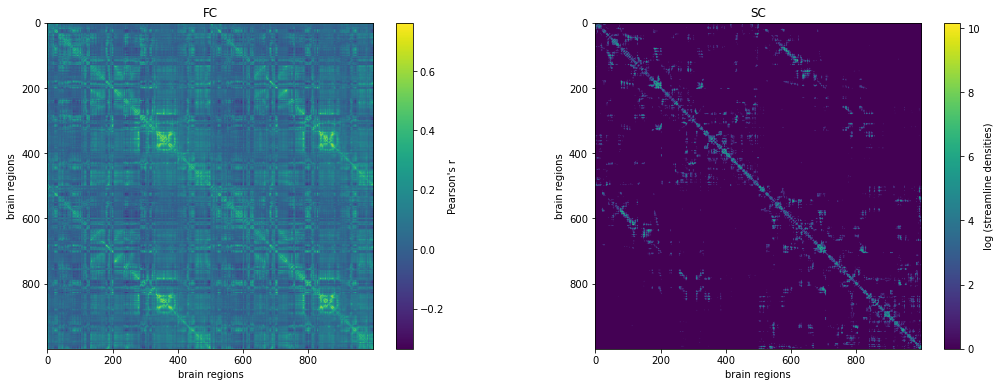

In [4]:
import matplotlib.pyplot as plt  # Python plotting library

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Functional connectivity
im1 = axes[0].imshow(FC)
axes[0].set_xlabel("brain regions")
axes[0].set_ylabel("brain regions")
axes[0].set_title("FC")
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label("Pearson's r")

# Structural connectivity
im2 = axes[1].imshow(SC)
axes[1].set_xlabel("brain regions")
axes[1].set_ylabel("brain regions")
axes[1].set_title("SC")
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label("log (streamline densities)")

- ### We can look at the relationship between connection weight and physical distance

        In the structural connectome, we see a strong correlation negative between structural connectivity weights and euclidean distance (Roberts et al., 2016, Neuroimage).

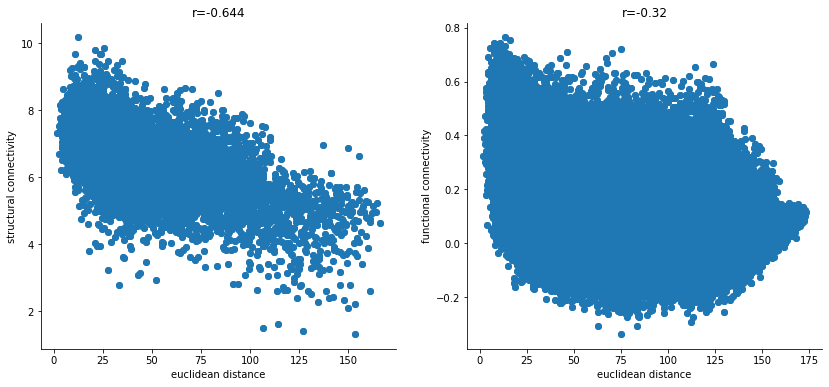

In [5]:
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

distances = cdist(coords, coords)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(distances[SC > 0], SC[SC > 0])
axes[0].set_xlabel("euclidean distance")
axes[0].set_ylabel("structural connectivity")
axes[0].set_title("r=" + str(round(pearsonr(distances[SC > 0], SC[SC > 0])[0], 3)))
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

axes[1].scatter(distances[FC != 0], FC[FC != 0])
axes[1].set_xlabel("euclidean distance")
axes[1].set_ylabel("functional connectivity")
axes[1].set_title("r=" + str(round(pearsonr(distances[FC != 0], FC[FC != 0])[0], 3)))
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

- ### We can compare the SC and FC weights
    
        We see a correlation between structural and functional connectivity that is however not perfect: the presence of a functional relationship between a pair of brain regions does not necessarily imply the presence of structural connection (Suarez et al., 2020, Trends in Cognitive Science).

Text(0.5, 1.0, 'r=0.359')

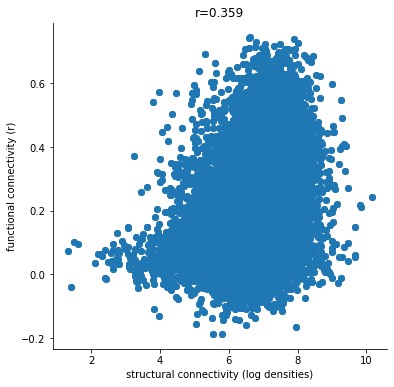

In [6]:
plt.figure(figsize=(6, 6))
plt.scatter(SC[SC > 0], FC[SC > 0])
plt.xlabel("structural connectivity (log densities)")
plt.ylabel("functional connectivity (r)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("r=" + str(round(pearsonr(SC[SC > 0], FC[SC > 0])[0], 3)))

- ### We can look at the strength distribution of the structural connectome

        The structural connectome has a heavy-tailed degree distribution with high-degree hubs

Text(0.5, 0, 'node strength')

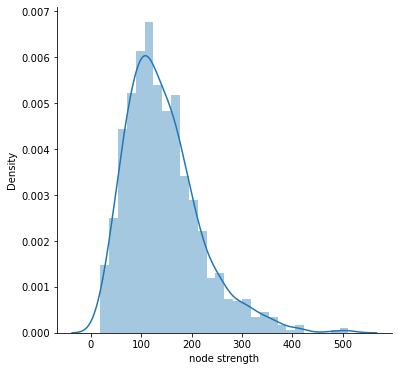

In [7]:
import seaborn as sns

SC_strength = SC.sum(axis=0)

plt.figure(figsize=(6,6))
sns.distplot(SC_strength)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("node strength")

- ### Let's use modularity maximization to identify communities of strongly interconnected brain regions in the FC matrix

        See Sporns & Betzel (2016) Annual Review of Psychology for a review of commonly used methods for community detection in the brain

We must remove the negative values from the FC matrix

In [8]:
FC_non_neg = FC.copy()
FC_non_neg[FC < 0] = 0

Let's use the Louvain algorithm (from the Brain Connectivity Toolbox) [Blondel et al., 2008; Journal of Statistical Mechanics: Theory and Experiment]

In [9]:
import bct  # Brain Connectivity Toolbox

ci, Q = bct.community_louvain(FC_non_neg, gamma=1.5)
num_ci = len(np.unique(ci))
print('{} clusters detected with a modularity of {:.2f}.'.format(num_ci, Q))


12 clusters detected with a modularity of 0.13.


We can visualize the communities by re-ordering the nodes in our matrix

<AxesSubplot:>

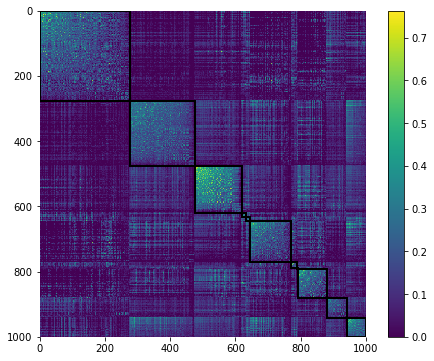

In [10]:
from netneurotools import plotting
plotting.plot_mod_heatmap(FC_non_neg, ci, figsize=(8, 6))

The Louvain algorithm is greedy so different instantiations will return different community assignments. We can run the algorithm ~100 times to see this discrepancy:

In [11]:
ci = [bct.community_louvain(FC_non_neg, gamma=1.5)[0] for n in range(100)]

Let's plot the assignment x ROIs matrix

[Text(0, 0.5, 'Assignments'), Text(0.5, 0, 'ROIs')]

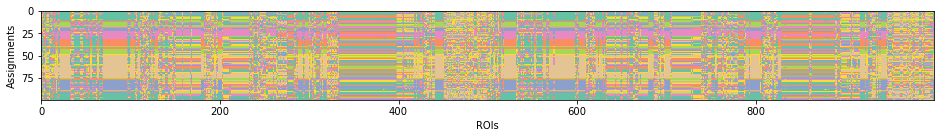

In [12]:
from netneurotools import cluster

# Let's first re-order the assignements to try to "make them look better"
reodered_ci = cluster.reorder_assignments(ci, col_sort=False, return_index=False)

# Plot the reodered assignemnts X ROIs
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
im = ax.imshow(reodered_ci, cmap='Set2')
ax.set(ylabel='Assignments', xlabel='ROIs')

We’ll provide these different assignments to our consensus-finding algorithm which will generate one final community assignment vector (Bassett, 2013, Chaos):

<AxesSubplot:>

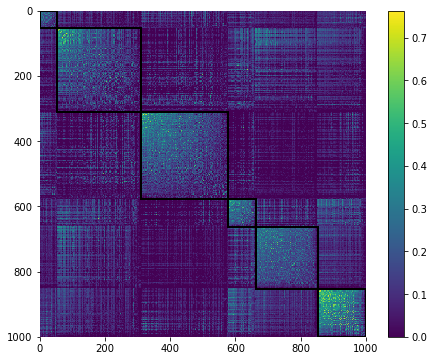

In [13]:
consensus = cluster.find_consensus(np.column_stack(ci), seed=1234)
plotting.plot_mod_heatmap(FC_non_neg, consensus, cmap='viridis', figsize=(8, 6))

Let's look at what these communities look like, in physical space.

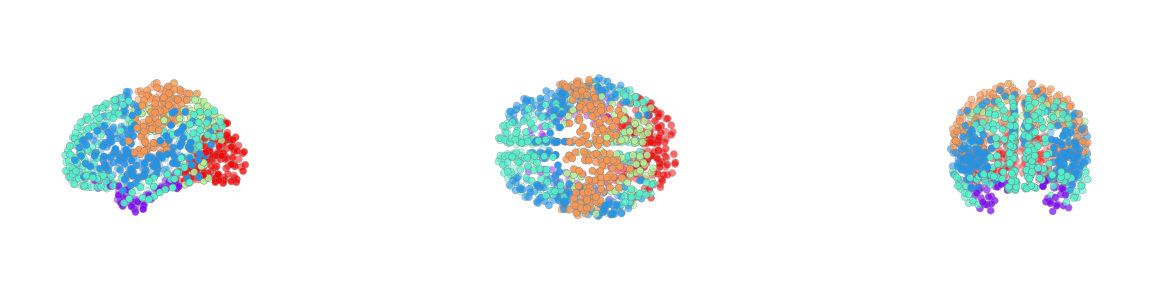

In [14]:
fig = plot_point_brain(consensus, coords, views=['sag', 'ax', 'cor'], views_orientation='horizontal',
                       views_size=(6, 4), cmap="rainbow")

We see that one of these communities looks a lot like the default mode network.

 - ### Let's try to identify hub regions in the functional connectome

Participation coefficient

In [15]:
ppc = bct.participation_coef(FC_non_neg, consensus)

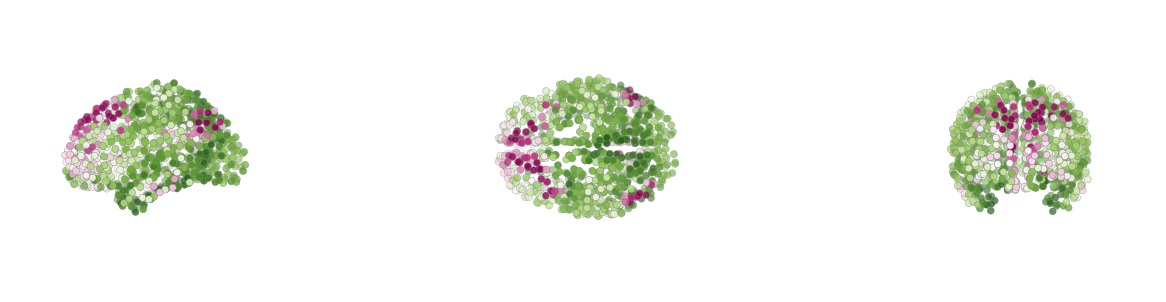

In [16]:
fig = plot_point_brain(ppc, coords, views=['sag', 'ax', 'cor'], views_orientation='horizontal',
                       views_size=(6, 4), cmap="PiYG")

Node strength

In [17]:
strength = FC_non_neg.sum(axis=0)

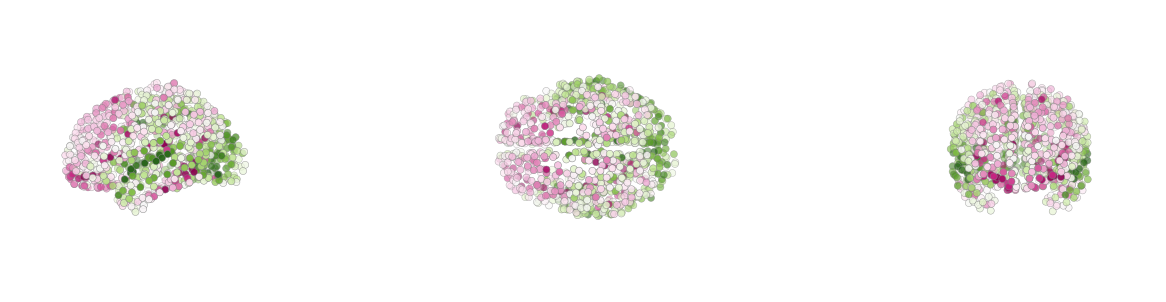

In [18]:
fig = plot_point_brain(strength, coords, views=['sag', 'ax', 'cor'], views_orientation='horizontal',
                       views_size=(6, 4), cmap="PiYG")

Eigenvector centrality

In [19]:
ec = bct.eigenvector_centrality_und(FC_non_neg)

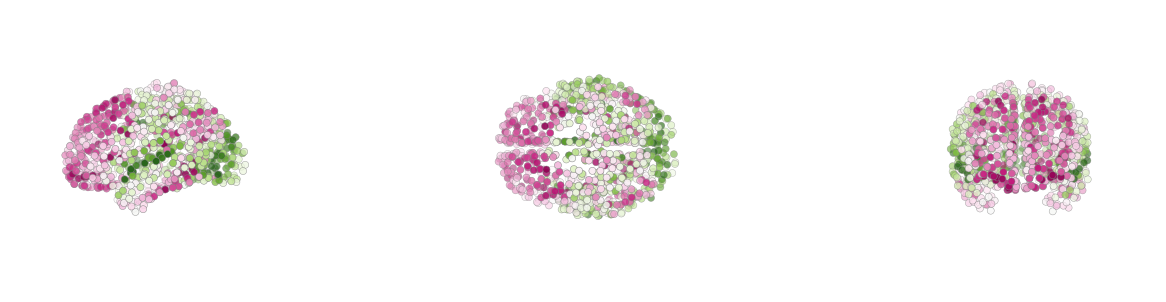

In [20]:
fig = plot_point_brain(ec, coords, views=['sag', 'ax', 'cor'], views_orientation='horizontal',
                       views_size=(6, 4), cmap="PiYG")

- ### Let's try to identify the main axis of variance in the functional connectivity

        The main axis of variance in functional connectivity is thought to replicate the functional hierarchy of the brain, with on one side sensory-motor regions and on the other side transmodal/higher-order brain regions (Margulies et al., 2016, PNAS).

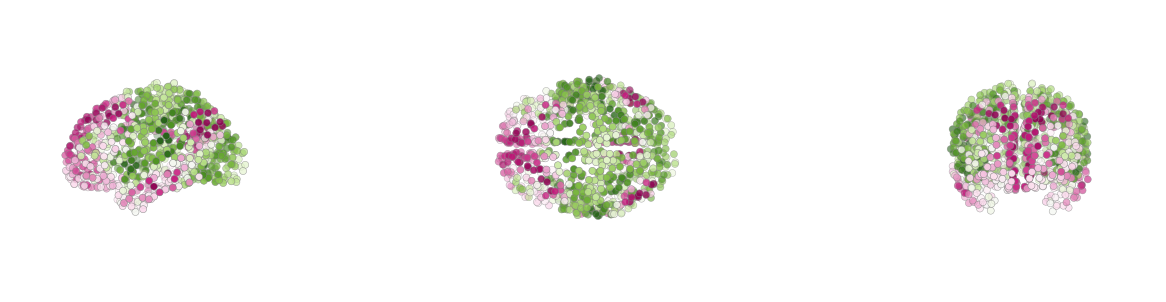

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(FC)
FCpcs = pca.components_.T

fig = plot_point_brain(-FCpcs[:, 0], coords, views=['sag', 'ax', 'cor'], views_orientation='horizontal',
                       views_size=(6, 4), cmap="PiYG")